In [1]:
%pylab inline
import pylab as pl
import numpy as np

# Some nice default configuration for plots
pl.rcParams['figure.figsize'] = 10, 7.5
pl.rcParams['axes.grid'] = True
pl.gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 720x540 with 0 Axes>

# Text Feature Extraction for Classification and Clustering

Outline of this section:

- Turn a corpus of text documents into **feature vectors** using a **Bag of Words** representation,
- Train a simple text classifier on the feature vectors,
- Wrap the vectorizer and the classifier with a **pipeline**,
- Cross-validation and (manual) **model selection** on the pipeline.
- Qualitative **model inspection**

## Text Classification in 20 lines of Python

Let's start by implementing a canonical text classification example:

- The 20 newsgroups dataset: around 18000 text posts from 20 newsgroups forums
- Bag of Words features extraction with TF-IDF weighting
- Naive Bayes classifier or Linear Support Vector Machine for the classifier itself

In [2]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the text data
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
twenty_train_subset = load_files('datasets/20news-bydate-train/',
    categories=categories, encoding='latin-1')
twenty_test_subset = load_files('datasets/20news-bydate-test/',
    categories=categories, encoding='latin-1')

# Turn the text documents into vectors of word frequencies
vectorizer = TfidfVectorizer(min_df=2)
X_train = vectorizer.fit_transform(twenty_train_subset.data)
y_train = twenty_train_subset.target

# Fit a classifier on the training set
classifier = MultinomialNB().fit(X_train, y_train)
print("Training score: {0:.1f}%".format(
    classifier.score(X_train, y_train) * 100))

# Evaluate the classifier on the testing set
X_test = vectorizer.transform(twenty_test_subset.data)
y_test = twenty_test_subset.target
print("Testing score: {0:.1f}%".format(
    classifier.score(X_test, y_test) * 100))

Training score: 95.1%
Testing score: 85.1%


Here is a workflow diagram summary of what happened previously:

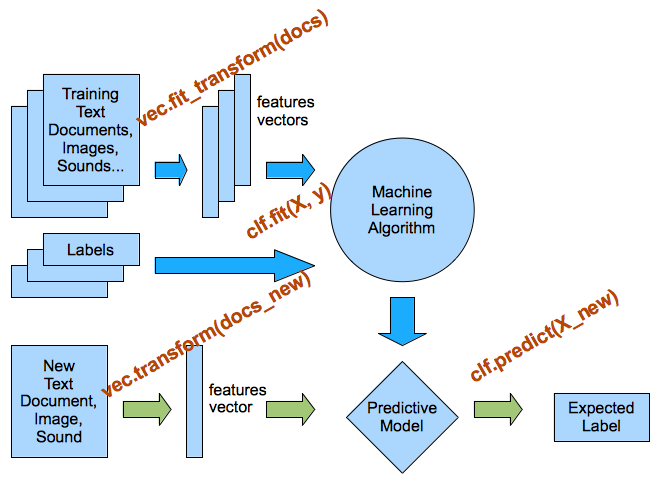

In [3]:
from IPython.core.display import Image, display
display(Image(filename='figures/supervised_scikit_learn.png'))

Let's now decompose what we just did to understand and customize each step:

### Loading the Dataset

Let's explore the dataset loading utility without passing a list of categories: in this case we load the full 20 newsgroups dataset in memory. The source website for the 20 newsgroups already provides a date-based train / test split that is made available using the `subset` keyword argument: 

In [ ]:
ls -l datasets/

In [ ]:
ls -lh datasets/20news-bydate-train

In [ ]:
ls -lh datasets/20news-bydate-train/alt.atheism/

The `load_files` function can load text files from a 2 levels folder structure assuming folder names represent categories:

In [ ]:
#print(load_files.__doc__)

In [ ]:
all_twenty_train = load_files('datasets/20news-bydate-train/',
  encoding='latin-1', random_state=42)
all_twenty_test = load_files('datasets/20news-bydate-test/',
    encoding='latin-1', random_state=42)

In [ ]:
all_target_names = all_twenty_train.target_names
all_target_names

In [ ]:
all_twenty_train.target

In [ ]:
all_twenty_train.target.shape

In [ ]:
all_twenty_test.target.shape

In [ ]:
len(all_twenty_train.data)

In [ ]:
type(all_twenty_train.data[0])

In [ ]:
def display_sample(i, dataset):
    print("Class name: " + dataset.target_names[dataset.target[i]])
    print("Text content:\n")
    print(dataset.data[i])

In [ ]:
display_sample(0, all_twenty_train)

In [ ]:
display_sample(1, all_twenty_train)

Let's compute the (uncompressed, in-memory) size of the training and test sets in MB assuming an 8 bit encoding (in this case, all chars can be encoded using the latin-1 charset).

In [ ]:
def text_size(text, charset='iso-8859-1'):
    return len(text.encode(charset)) * 8 * 1e-6

train_size_mb = sum(text_size(text) for text in all_twenty_train.data) 
test_size_mb = sum(text_size(text) for text in all_twenty_test.data)

print("Training set size: {0} MB".format(int(train_size_mb)))
print("Testing set size: {0} MB".format(int(test_size_mb)))

If we only consider a small subset of the 4 categories selected from the initial example:

In [ ]:
train_subset_size_mb = sum(text_size(text) for text in twenty_train_subset.data) 
test_subset_size_mb = sum(text_size(text) for text in twenty_test_subset.data)

print("Training set size: {0} MB".format(int(train_subset_size_mb)))
print("Testing set size: {0} MB".format(int(test_subset_size_mb)))

### Extracting Text Features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVectorizer()

In [ ]:
vectorizer = TfidfVectorizer(min_df=1)

%time X_train = vectorizer.fit_transform(twenty_train_subset.data)

The results is not a `numpy.array` but instead a `scipy.sparse` matrix. This datastructure is quite similar to a 2D numpy array but it does not store the zeros.

In [ ]:
X_train

scipy.sparse matrices also have a shape attribute to access the dimensions:

In [ ]:
n_samples, n_features = X_train.shape

This dataset has around 2000 samples (the rows of the data matrix):

In [ ]:
n_samples

This is the same value as the number of strings in the original list of text documents:

In [ ]:
len(twenty_train_subset.data)

The columns represent the individual token occurrences:

In [ ]:
n_features

This number is the size of the vocabulary of the model extracted during fit in a Python dictionary:

In [ ]:
type(vectorizer.vocabulary_)

In [ ]:
len(vectorizer.vocabulary_)

The keys of the `vocabulary_` attribute are also called feature names and can be accessed as a list of strings.

In [ ]:
len(vectorizer.get_feature_names())

Here are the first 10 elements (sorted in lexicographical order):

In [ ]:
vectorizer.get_feature_names()[:10]

Let's have a look at the features from the middle:

In [ ]:
vectorizer.get_feature_names()[n_features // 2:n_features // 2 + 10]

In adition to the text of the documents that has been vectorized one also has access to the label information:

In [ ]:
y_train = twenty_train_subset.target
target_names = twenty_train_subset.target_names
target_names

In [ ]:
y_train.shape

In [ ]:
y_train

In [ ]:
# We can shape that we have the same number of samples for the input data and the labels:
X_train.shape[0] == y_train.shape[0]

Now that we have extracted a vector representation of the data, it's a good idea to project the data on the first 2D of a Principal Component Analysis to get a feel of the data. Note that the `RandomizedPCA` class can accept `scipy.sparse` matrices as input (as an alternative to numpy arrays):

In [ ]:
from sklearn.decomposition import RandomizedPCA

%time X_train_pca = RandomizedPCA(n_components=2).fit_transform(X_train.toarray())

In [ ]:
from itertools import cycle

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, c in zip(np.unique(y_train), cycle(colors)):
    pl.scatter(X_train_pca[y_train == i, 0],
               X_train_pca[y_train == i, 1],
               c=c, label=target_names[i], alpha=0.5)
    
_ = pl.legend(loc='best')

We can observe that there is a large overlap of the samples from different categories. This is to be expected as the PCA linear projection projects data from a 34118 dimensional space down to 2 dimensions: data that is linearly separable in 34118D is often no longer linearly separable in 2D.
    
Still we can notice an interesting pattern: the newsgroups on religion and atheism occupy the much the same region and computer graphics and space science / space overlap more together than they do with the religion or atheism newsgroups.

### Training a Classifier on Text Features

We can now train a classifier, for instance a Multinomial Naive Bayesian classifier which is a fast baseline for text classification tasks:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=0.1)
clf

In [ ]:
clf.fit(X_train, y_train)

We can now evaluate the classifier on the testing set. Let's first use the builtin score function, which is the rate of correct classification in the test set:

In [ ]:
X_test = vectorizer.transform(twenty_test_subset.data)
y_test = twenty_test_subset.target

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
clf.score(X_test, y_test)

We can also compute the score on the test set and observe that the model is both overfitting and underfitting a bit at the same time:

In [ ]:
clf.score(X_train, y_train)

### Introspecting the Behavior of the Text Vectorizer

The text vectorizer has many parameters to customize it's behavior, in particular how it extracts tokens:

In [ ]:
TfidfVectorizer()

In [ ]:
print(TfidfVectorizer.__doc__)

The easiest way to introspect what the vectorizer is actually doing for a given test of parameters is call the `vectorizer.build_analyzer()` to get an instance of the text analyzer it uses to process the text:

In [ ]:
analyzer = TfidfVectorizer().build_analyzer()
analyzer("I love scikit-learn: this is a cool Python lib!")

You can notice that all the tokens are lowercase, that the single letter word "I" was dropped, and that hyphenation is used. Let's change some of that default behavior:

In [ ]:
analyzer = TfidfVectorizer(
    preprocessor=lambda text: text,  # disable lowercasing
    token_pattern=r'(?u)\b[\w-]+\b', # treat hyphen as a letter
                                      # do not exclude single letter tokens
).build_analyzer()

analyzer("I love scikit-learn: this is a cool Python lib!")

The analyzer name comes from the Lucene parlance: it wraps the sequential application of:

- text preprocessing (processing the text documents as a whole, e.g. lowercasing)
- text tokenization (splitting the document into a sequence of tokens)
- token filtering and recombination (e.g. n-grams extraction, see later)

The analyzer system of scikit-learn is much more basic than lucene's though.

**Exercise**:

- Write a pre-processor callable (e.g. a python function) to remove the headers of the text a newsgroup post.
- Vectorize the data again and measure the impact on performance of removing the header info from the dataset.
- Do you expect the performance of the model to improve or decrease? What is the score of a uniform random classifier on the same dataset?

Hint: the `TfidfVectorizer` class can accept python functions to customize the `preprocessor`, `tokenizer` or `analyzer` stages of the vectorizer.
    
- type `TfidfVectorizer()` alone in a cell to see the default value of the parameters

- type `TfidfVectorizer.__doc__` to print the constructor parameters doc or `?` suffix operator on a any Python class or method to read the docstring or even the `??` operator to read the source code.

**Solution**:

In [ ]:
# %load solutions/05B_strip_headers.py

## Assembling a Pipeline for Model Validation

The feature extraction class has many options to customize its behavior:

In [ ]:
print(TfidfVectorizer.__doc__)

In order to evaluate the impact of the parameters of the feature extraction one can chain a configured feature extraction and linear classifier (as an alternative to the naive Bayes model:

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline((
    ('vec', TfidfVectorizer(min_df=1, max_df=0.8, use_idf=True)),
    ('clf', PassiveAggressiveClassifier(C=1)),
))

Such a pipeline can then be used to evaluate the performance on the test set:

In [ ]:
pipeline.fit(twenty_train_subset.data, twenty_train_subset.target)

print("Train score:")
print(pipeline.score(twenty_train_subset.data, twenty_train_subset.target))
print("Test score:")
print(pipeline.score(twenty_test_subset.data, twenty_test_subset.target))

## Introspecting Model Performance

### Displaying the Most Discriminative Features

Let's collect info on the fitted components of the previously trained model:

In [ ]:
vec_name, vec = pipeline.steps[0]
clf_name, clf = pipeline.steps[1]

feature_names = vec.get_feature_names()

feature_weights = clf.coef_

feature_weights.shape

By sorting the feature weights on the linear model and asking the vectorizer what their names is, one can get a clue on what the model did actually learn on the data:

In [ ]:
def display_important_features(feature_names, target_names, weights, n_top=30):
    for i, target_name in enumerate(target_names):
        print("Class: " + target_name)
        print("")
        
        sorted_features_indices = weights[i].argsort()[::-1]
        
        most_important = sorted_features_indices[:n_top]
        print(", ".join("{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in most_important))
        print("...")
        
        least_important = sorted_features_indices[-n_top:]
        print(", ".join("{0}: {1:.4f}".format(feature_names[j], weights[i, j])
                        for j in least_important))
        print("")
        
display_important_features(feature_names, target_names, feature_weights)

### Displaying the per-class Classification Reports

In [ ]:
from sklearn.metrics import classification_report

predicted = pipeline.predict(twenty_test_subset.data)

In [ ]:
print(classification_report(twenty_test_subset.target, predicted,
                            target_names=target_names))

### Printing the Confusion Matrix

The confusion matrix summarize which class where by having a look at off-diagonal entries: here we can see that articles about atheism have been wrongly classified as being about religion 57 times for instance: 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(twenty_test_subset.target, predicted)